# EECS 731 Group Project: Traveling with Confidence?

In this project, we are reading from the [Our World in Data (OWIL)](https://ourworldindata.org/coronavirus-source-data) and [Google's COVID-19 Community Mobility Reports](https://www.google.com/covid19/mobility/) which provide overview and trends for COVID-19 cases and public transit hub usage, respectively, on a per-country basis. In doing so, we seek to determine how much the two correlate and what additional information can be gained from them. In particular, we read the data for the following 10 countries (listed in alphabeticalorder):

- Canada (CA)
- France (FR)
- Germany (DE)
- Italy (IT)
- Japan (JP)
- Mexico (MX)
- South Korea (KR)
- Spain (ES)
- United Kingdom (GB)
- United States (US)

For each country, we investigate the following problem areas with the goal of answering questions related to each one:

- Regression (Do COVID cases correlate to transit usage? Are they an accurate indicator for future usage?)
- Time Series Forecasting (Given previous and current trends, what will most likely happen with future trends?)
- Anomaly Detection (Given the trends for a time period, which parts of that set stand out?)

In addition to the link above, the datasets we used can also be found in the data/raw/ directory. For the public transit datasets, since all of Google's mobility reports take up ~200MB collectively, we only include the mobility datasets for the countries we test.

## Python Imports

In [1]:
import os,sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neural_network import MLPRegressor
from statsmodels.tsa.arima_model import ARIMA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.metrics import mean_squared_error
from fbprophet import Prophet
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance

We also suppress the following warnings for the sake of improving output readability:

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from matplotlib.cbook import MatplotlibDeprecationWarning
from statsmodels.tools.sm_exceptions import ConvergenceWarning as CW2
from statsmodels.tools.sm_exceptions import HessianInversionWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=MatplotlibDeprecationWarning)
warnings.simplefilter(action='ignore', category=CW2)
warnings.simplefilter(action='ignore', category=HessianInversionWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

## Preparing Per-Country Values

Before we begin loading and working with the datasets, we first hardcode some necessary values/parameters for each country:

In [3]:
countries = ["United States", "Germany", "United Kingdom", "France", "Japan", 
             "Canada", "Spain", "South Korea", "Italy", "Mexico"]
codes = ["US", "DE", "GB", "FR", "JP", "CA", "ES", "KR", "IT", "MX"]
diff_days = [25, 18, 14, 21, 31, 20, 13, 26, 15, 32]
arima_vals = [8, 6, 8, 8, 8, 4, 8, 4, 8, 4]

Namely, each of the lists created above represent the following:

- countries: The name of the countries we test. These are used to get their respective COVID case data from the OWIL dataset.
- codes: The ISO 3166-1 alpha-2 two letter codes for each country. These are used in the naming scheme for Google mobility reports, so we use them to access each country transit hub data.
- diff_days: The number of days between each country's first reported COVID cases and 2/15/20. Since the Google mobility reports only start from 2/15/20, we remove the difference in days between the OWIL data and each country's transit hub data to ensure that both data groups are of equal length (since both datasets only go until 11/3/20, we only have to worry about removing data from earlier in 2020).
- arima_vals: In using the ARIMA model for Time Series Forecasting, the same order value can't be used for all countries. As such, each number in this list represents an ARIMA value that works and is used for the corresponding country.

After that, we then iterate through a for loop of each country (e.g. for country in countries ...), and investigate all three problem areas for all countries accordingly. 

However, for the sake of readability, we only display the results for the United States in this noteboook. The results for all countries can be seen in their respective folders in the visualizations/ directory, and we do discuss general performance in the Results section at the end of each problem area section below.

## Reading from the Raw Datasets

In order to access the necessary datasets, we first get each countries respective values from the lists created above. Since the US is first, we retrieve its values using the 0 index. Note that we use a variable for this in the actual for loop (e.g. index instead of 0).

In [4]:
country = countries[0]
code = codes[0]
diff = diff_days[0]
arima_val = arima_vals[0]

We those values, we first read from the OWID case data. Namely, we perform the following steps to get the data for the US:

- Get all rows where the "location" value is the "United States".
- Only keep the date, total cases, and new cases columns.
- Remove the difference in days (as described above) so that the data begins at 2/15/20.

In [5]:
covid_dataset = pd.read_csv("../data/raw/owid-covid-data.csv")
covid_cases = covid_dataset[covid_dataset["location"]=="{}".format(country)]
covid_cases = covid_cases.loc[:,("date", "total_cases", "new_cases", "new_cases_smoothed")].dropna()
covid_cases = covid_cases[diff:]
covid_cases

,date,total_cases,new_cases,new_cases_smoothed
50628,2020-02-15,15.0,0.0,0.429
50629,2020-02-16,15.0,0.0,0.429
50630,2020-02-17,15.0,0.0,0.429
50631,2020-02-18,15.0,0.0,0.286
50632,2020-02-19,15.0,0.0,0.286
...,...,...,...,...
50886,2020-10-30,8946154.0,88130.0,76830.571
50887,2020-10-31,9047427.0,101273.0,79108.286
50888,2020-11-01,9126361.0,78934.0,78519.429
50889,2020-11-02,9207362.0,81001.0,81599.571


We then get the transit hub data from the US's mobility report as follows:

- Get all rows that describe the entire country (i.e. where no regions/subregions are specified). This effectively gives us mobility data from 2/15/20 to 11/3/20.
- Only keep the date and transit hub trend columns.

In [6]:
daily_transits = pd.read_csv("../data/raw/mobility_reports/2020_{}_Region_Mobility_Report.csv".format(code))[:263]
daily_transits = daily_transits.loc[:,("date", "transit_stations_percent_change_from_baseline")].dropna()
daily_transits

,date,transit_stations_percent_change_from_baseline
0,2020-02-15,3.0
1,2020-02-16,2.0
2,2020-02-17,-9.0
3,2020-02-18,1.0
4,2020-02-19,1.0
...,...,...
258,2020-10-30,-32.0
259,2020-10-31,-23.0
260,2020-11-01,-29.0
261,2020-11-02,-35.0


For both datasets, we rename the columns to improve their readability. We then make sure both datasets have an equal number of rows. If they do, we create a new DataFrame from both datasets and save it to the data/processed/ directory.

In [7]:
covid_cases = covid_cases.rename(columns={"date":"Date", "total_cases":"Total", 
                                 "new_cases":"New", "new_cases_smoothed":"New_smoothed"})
daily_transits = daily_transits.rename(columns={"date":"Date",  
                                       "transit_stations_percent_change_from_baseline":"Transits"})

assert len(covid_cases) == len(daily_transits), "Cases={}, Transits={}".format(len(covid_cases), len(daily_transits))

df = pd.DataFrame(data={"Date":covid_cases["Date"],"Total_cases":covid_cases["Total"],
                        "New_cases":covid_cases["New"],"New_smoothed":covid_cases["New_smoothed"], 
                        "Transits":daily_transits["Transits"].values}).reset_index()
df.to_csv("../data/processed/{}.csv".format(code)) 
df

,index,Date,Total_cases,New_cases,New_smoothed,Transits
0,50628,2020-02-15,15.0,0.0,0.429,3.0
1,50629,2020-02-16,15.0,0.0,0.429,2.0
2,50630,2020-02-17,15.0,0.0,0.429,-9.0
3,50631,2020-02-18,15.0,0.0,0.286,1.0
4,50632,2020-02-19,15.0,0.0,0.286,1.0
...,...,...,...,...,...,...
258,50886,2020-10-30,8946154.0,88130.0,76830.571,-32.0
259,50887,2020-10-31,9047427.0,101273.0,79108.286,-23.0
260,50888,2020-11-01,9126361.0,78934.0,78519.429,-29.0
261,50889,2020-11-02,9207362.0,81001.0,81599.571,-35.0


## Pre-Evaluation

Before we begin evaluating different models on the data read above, we first perform two setup steps:

- If it doesn't already exist, we create a new subdirectory to all figures and graphs are saved.
- We plot and save the transit hub trends for the country in the country's subdirectory.

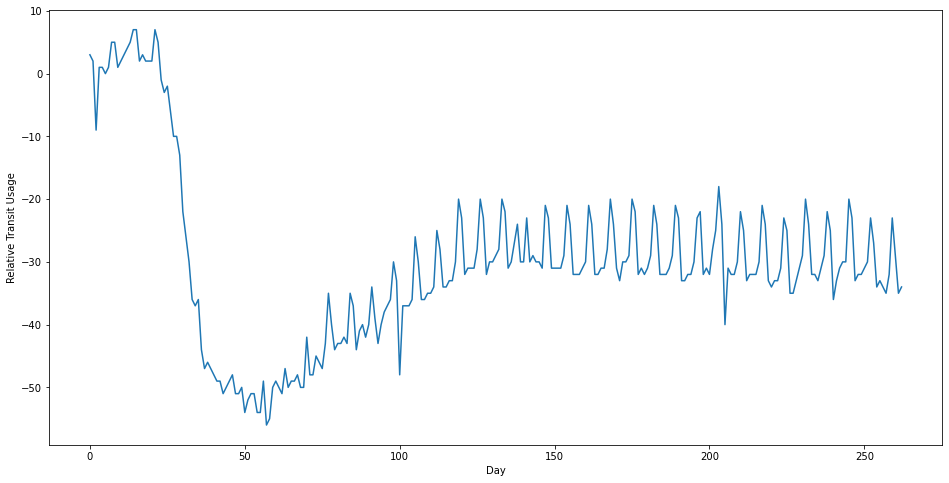

In [8]:
foldername = "../visualizations/{}".format(code)
if not os.path.exists(foldername):
    os.makedirs(foldername)

plt.clf()
plt.plot(range(len(daily_transits)), daily_transits["Transits"])
plt.xlabel("Day")
plt.ylabel("Relative Transit Usage")
plt.gcf().set_size_inches((16.0,8.0), forward=False)
plt.savefig("{}/transit.png".format(foldername), bbox_inches='tight', dpi=100)

# Regression

The first problem area we investigate is Regression. With this area, we seek to evaluate the correlation between COVID cases and transit hub usage in each country. To do this, we employ three Regression models:

- Random Forest
- Gradient Boosting
- MLP Regressor (Neural Network)

Before we evaluate the models, we first prepare the data by retrieving the necessary COVID case features (total and new cases) and the transit hub usage data. We then use that data to create train and test sets we use for each model and an x_range variable that is used for plotting the results.

In [9]:
feature_set = covid_cases.loc[:,("Total","New")]
output_set = np.asarray(daily_transits["Transits"], dtype=np.int32).reshape(-1,1)
cases_train,cases_test,transport_train,transport_test = train_test_split(feature_set, output_set, test_size=0.5, random_state = 0)
x_range = range(len(cases_test))

With the train and test sets, we first evaluate the Random Forest and Gradient Boosting models.

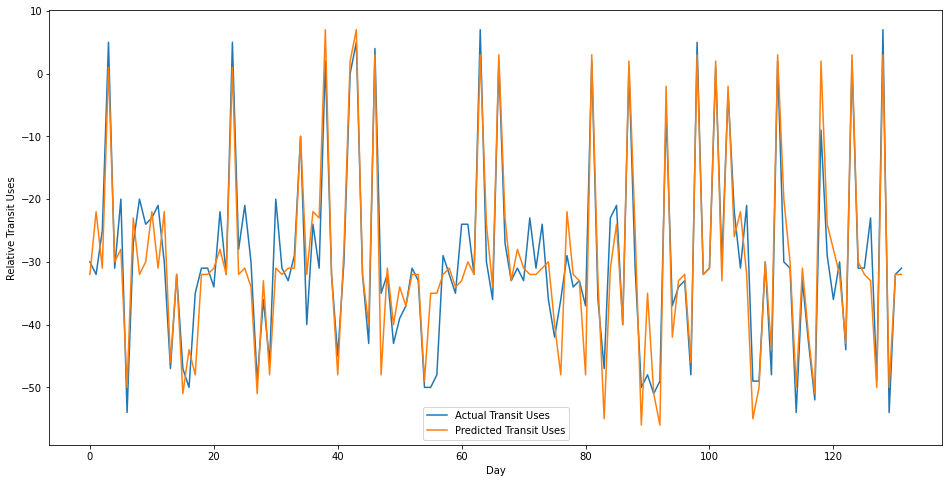

In [10]:
randomForest = RandomForestClassifier(n_estimators = 10)
rf_pred = randomForest.fit(cases_train, transport_train.ravel()).predict(cases_test)
plt.clf()
plt.plot(x_range, transport_test, label="Actual Transit Uses")
plt.plot(x_range, rf_pred, label="Predicted Transit Uses")
plt.xlabel("Day")
plt.ylabel("Relative Transit Uses")
plt.legend()
plt.gcf().set_size_inches((16.0,8.0), forward=False)
plt.savefig("{}/Regression_RandomForest.png".format(foldername), bbox_inches='tight', dpi=100)

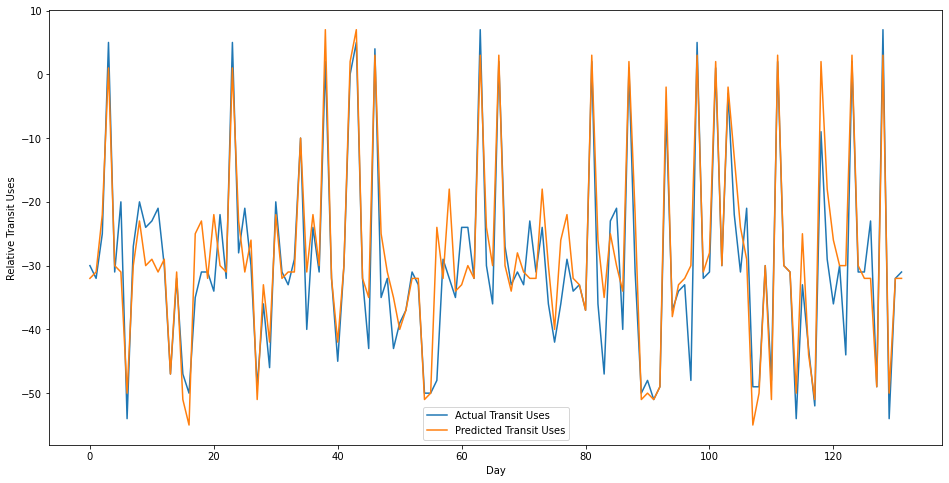

In [11]:
gradBoost = GradientBoostingClassifier()
gb_pred = gradBoost.fit(cases_train, transport_train.ravel()).predict(cases_test)
plt.clf()
plt.plot(x_range, transport_test, label="Actual Transit Uses")
plt.plot(x_range, gb_pred, label="Predicted Transit Uses")
plt.xlabel("Day")
plt.ylabel("Relative Transit Uses")
plt.legend()
plt.gcf().set_size_inches((16.0,8.0), forward=False)
plt.savefig("{}/Regression_GradientBoost.png".format(foldername), bbox_inches='tight', dpi=100)

When evaluating the MLP Regressor model, we also perform and save the results of MinMax preprocessing on the feature set as doing so improves the model's performance. We didn't do this for the other two models as they perform better with the raw data values.

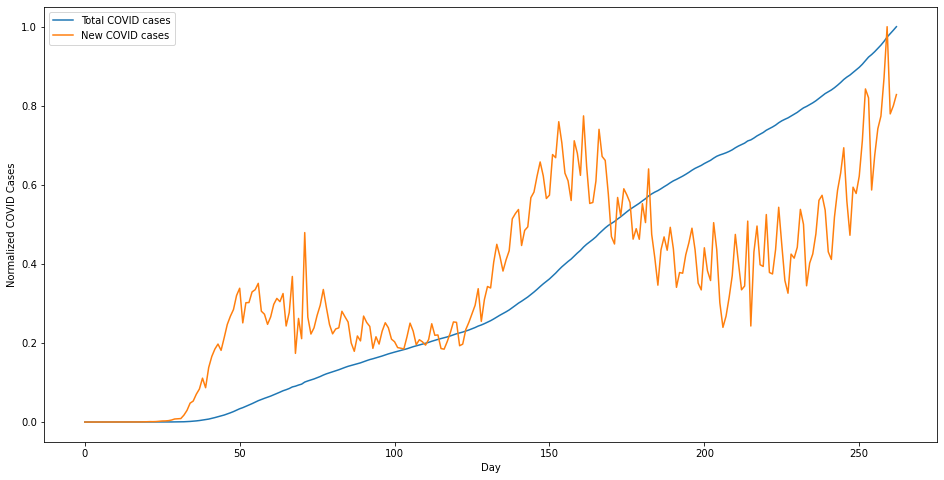

In [12]:
minMax = MinMaxScaler()
feature_set = minMax.fit_transform(feature_set)
cases_train,cases_test,transport_train,transport_test = train_test_split(feature_set, output_set, test_size=0.5, random_state = 0) #, shuffle=False)
plt.clf()
plt.plot(range(len(feature_set)), feature_set[:,0], label="Total COVID cases")
plt.plot(range(len(feature_set)), feature_set[:,1], label="New COVID cases")
plt.xlabel("Day")
plt.ylabel("Normalized COVID Cases")
plt.legend()
plt.gcf().set_size_inches((16.0,8.0), forward=False)
plt.savefig("{}/Cases_Normalized.png".format(foldername), bbox_inches='tight', dpi=100)

From there, we evaluate the MLP Regressor model accordingly.

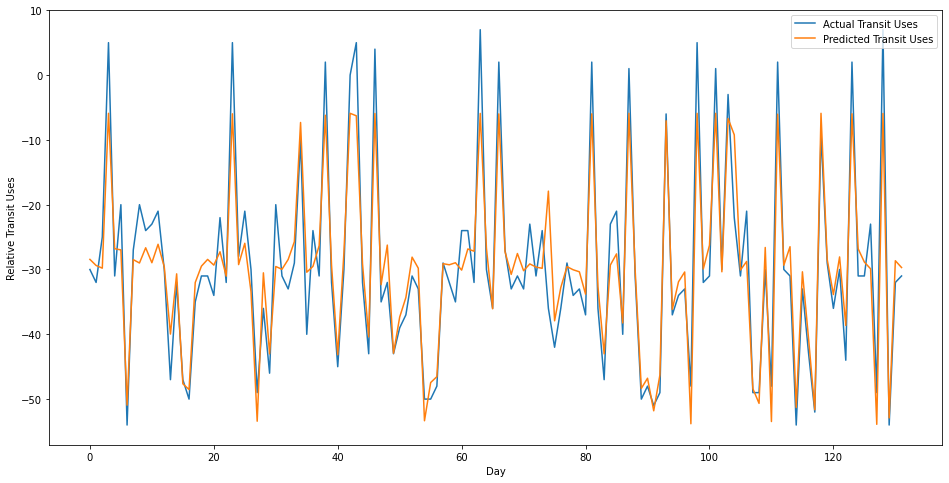

In [13]:
neuralNetwork = MLPRegressor(max_iter=10000)
nn_pred = neuralNetwork.fit(cases_train, transport_train.ravel()).predict(cases_test)
plt.clf()
plt.plot(x_range, transport_test, label="Actual Transit Uses")
plt.plot(x_range, nn_pred, label="Predicted Transit Uses")
plt.xlabel("Day")
plt.ylabel("Relative Transit Uses")
plt.legend()
plt.gcf().set_size_inches((16.0,8.0), forward=False)
plt.savefig("{}/Regression_NeuralNetwork.png".format(foldername), bbox_inches='tight', dpi=100)

Finally, to compare the models' performance, we calculate and display the root-mean-squared-error (RMSE) values.

In [14]:
print("RF stdev = {:.2f}".format(sqrt(mean_squared_error(rf_pred, transport_test.ravel()))))
print("GB stdev = {:.2f}".format(sqrt(mean_squared_error(gb_pred, transport_test.ravel()))))
print("NN stdev = {:.2f}".format(sqrt(mean_squared_error(nn_pred, transport_test.ravel()))))

RF stdev = 5.44
GB stdev = 5.80
NN stdev = 5.17


## Regression / Time Series

As can be seen in the results for the US, the MLP Regressor model had the best performance. However, we found that no single model performed the best across all of the countries tested and, instead, they all had instances where they performed the best. That being said, for all of the countries tested, we did see that COVID cases and transit hub usage were correlated as some, if not all, of the models achieved relatively low RMSE rates. 

Based on these findings, we also wanted to investigate whether COVID cases could be used as an accurate indicator for predicting future transit hub usage trends. To do this, we took the model that performed the best for each country and performed the same evaluations. In this case, though, we didn't perform any shuffling of the input data. That is, the training set that is generated represents the first half of the data, temporally speaking, while the testing set represents the second half.

For example, with the US we reran the MLP Regressor model, but with the unshuffled train and test sets.

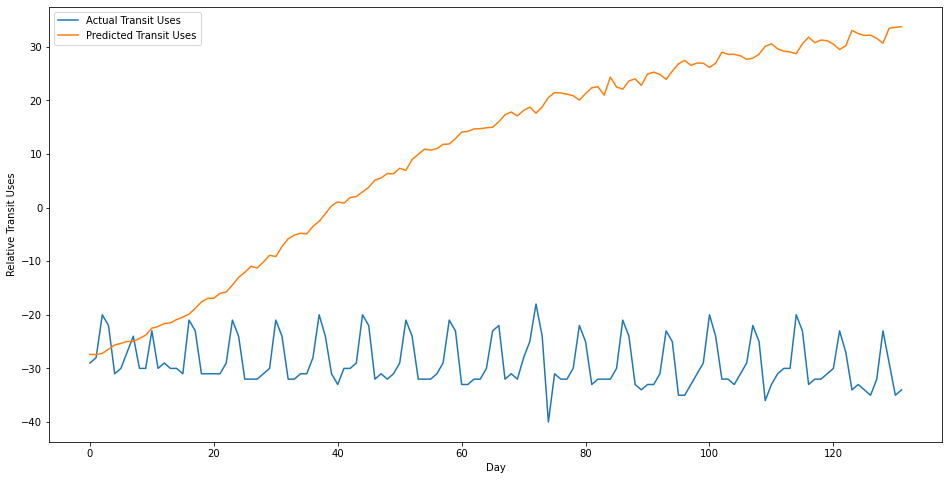

In [15]:
cases_train,cases_test,transport_train,transport_test = train_test_split(feature_set, output_set, test_size=0.5, random_state = 0, shuffle=False)
x_range = range(len(cases_test))

neuralNetwork = MLPRegressor(max_iter=10000)
nn_pred = neuralNetwork.fit(cases_train, transport_train.ravel()).predict(cases_test)
plt.clf()
plt.plot(x_range, transport_test, label="Actual Transit Uses")
plt.plot(x_range, nn_pred, label="Predicted Transit Uses")
plt.xlabel("Day")
plt.ylabel("Relative Transit Uses")
plt.legend()
plt.gcf().set_size_inches((16.0,8.0), forward=False)
plt.savefig("{}/Regression_TimeSeries.png".format(foldername), bbox_inches='tight', dpi=100)

In this case, we see that the MLP Regressor model isn't able to accurately predict the future transit hub trends given previous COVID case trends. We also found this to be the case for all of the other countries that we tested.

## Results

In the end, we found that COVID cases and transit hub usage do correlate in the context of a given time period. As such, Regression models can be used with relative success for predicting usage trends given the cases within that time period's dataset. 

However, when we try to apply those same models in order to predict future COVID cases, we instead find that they are less suited for that specific application. Namely, when we try to simulate future predictions by training and testing the models on unshuffled data, we see that there are noticeable difference between the model's prediction and the transit hub trends that actually transpired. As such, the Regression approach can't be used for performing accurate forecasting.

# Time Series Forecasting

The second problem area we investigate in Time Series Forecasting. With this area, we week to predict future public transportation usage trends given previous and current trends. To do this, we employ two Time Series Forecasting models:

- ARIMA
- Facebook Prophet

Unlike the Regression model tests, we only use the daily transit hub usage dataset. As such, we are able to directly run both models.

First, we performed ARIMA forecasting:

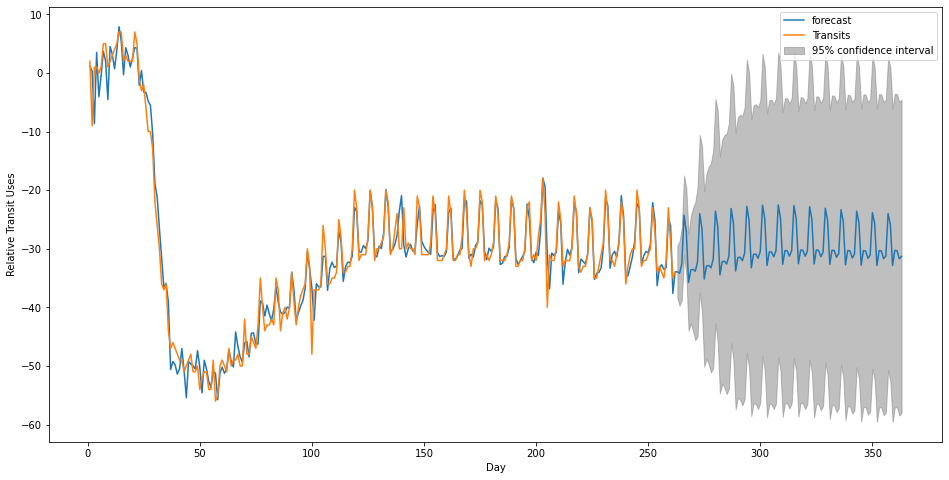

In [16]:
arima = ARIMA(daily_transits["Transits"], order=(arima_val,0,arima_val))
arima_pred = arima.fit(disp=0)
arima_pred.plot_predict(start=1,end=len(daily_transits["Transits"])+100)
plt.xlabel("Day")
plt.ylabel("Relative Transit Uses")
plt.gcf().set_size_inches((16.0,8.0), forward=False)
plt.savefig("{}/TimeSeries_ARIMA.png".format(foldername), bbox_inches='tight', dpi=100)

After that, we then performed forecasting with Facebook Prophet:

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


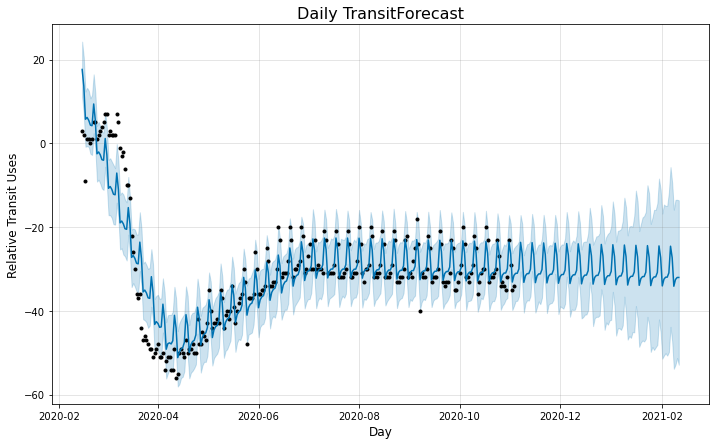

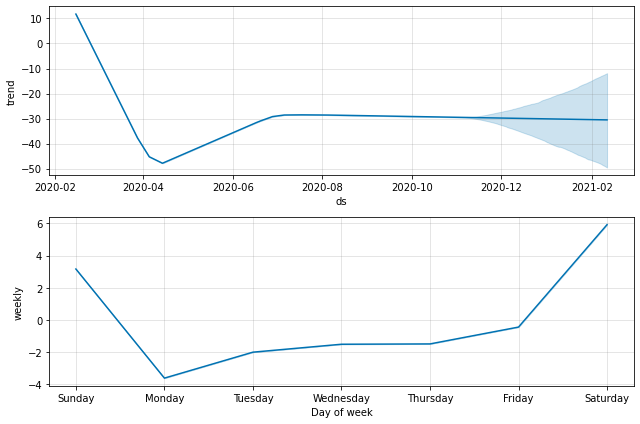

In [17]:
data = pd.DataFrame()
data["ds"] = daily_transits["Date"]
data["y"] = daily_transits["Transits"]
pht = Prophet()
pht.fit(data)
future_prices = pht.make_future_dataframe(periods=100)
forecast = pht.predict(future_prices)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig = pht.plot(forecast)
ax1 = fig.add_subplot(111)
ax1.set_title("Daily TransitForecast", fontsize=16)
ax1.set_xlabel("Day", fontsize=12)
ax1.set_ylabel("Relative Transit Uses", fontsize=12)
fig2 = pht.plot_components(forecast)
fig.savefig("{}/TimeSeries_fbProphet.png".format(foldername), bbox_inches='tight', dpi=100)
fig2.savefig("{}/TimeSeries_fbProphet_components.png".format(foldername), bbox_inches='tight', dpi=100)

## Results

In the end, we found that daily trends in public transportation usage are likely to remain stagnant. That is, for most countries, usage will continue to be at the same levels they have been for the past few months. We do find that some countries (e.g. France) are more likely to start seeing incremental usage increases over time. However, none of the countries we tested were predicted to approach pre-COVID usage levels.

Comparatively, we do find that the Facebook Prophet model does perform relatively better than the ARIMA model. While both models do output similar predictions for most of the countries, the Facebook Prophet model had far more confidence in its findings. To be more specific, when comparing the 95% confidence interval for both models, Facebook Prophet routinely had tighter intervals than the ARIMA model. As such, we are more inclined to trust the Facebook Prophet model's forecasting predictions.


# Anomaly Detection

The third and final problem area we investigate in Anomaly Detection. With this area, we seek to determine if there are any outlying days in a given time period with regards to the public transportation usage. To do this, we employ two Anomaly Detection models:

- Local Outlier Detection
- K Nearest Neighbors

Like the Time Series Forecasting model evaluations, we were able to directly run the models on the daily transit hub usage data.

We first ran the Local Outlier Detection model:

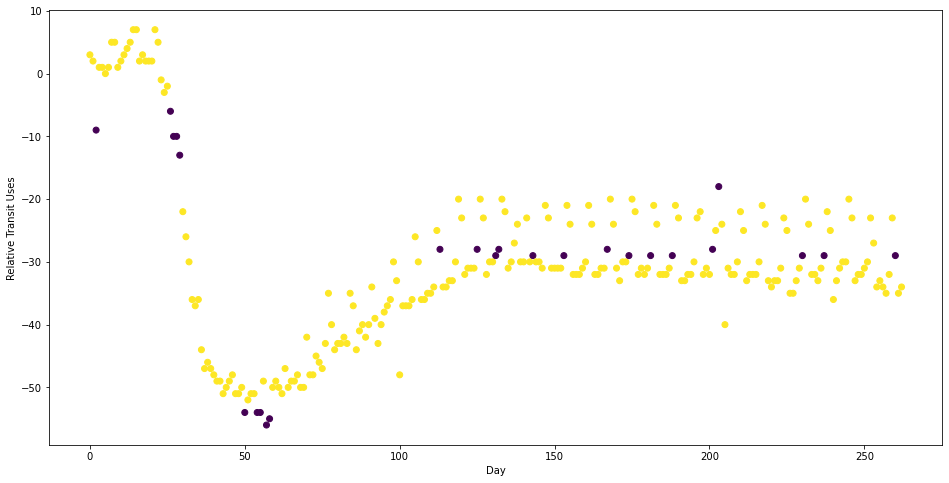

In [18]:
plt.clf()
localOutlier = LocalOutlierFactor()
local_pred = localOutlier.fit_predict(daily_transits["Transits"].values.reshape(-1,1))
x_range = range(len(daily_transits["Transits"]))
plt.scatter(x_range, daily_transits["Transits"], c=local_pred)
plt.xlabel("Day")
plt.ylabel("Relative Transit Uses")
plt.gcf().set_size_inches((16.0,8.0), forward=False)
plt.savefig("{}/AnomalyDetection_LocalOutlier.png".format(foldername), bbox_inches='tight', dpi=100)

After that, we then ran the K Nearest Neighbor model. Note that, depending on the version of Pandas installed, some functions may not be available (e.g. as_matrix). As such, we use a try/catch block to allow for different Pandas versions.

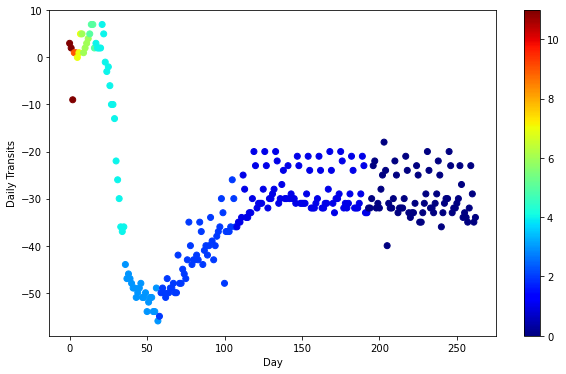

In [19]:
knn = 20
temp = daily_transits
temp = temp.drop(columns=["Date"])
try:
    nbrs = NearestNeighbors(n_neighbors=knn, metric=distance.minkowski).fit(temp.as_matrix())
    distances, indices = nbrs.kneighbors(temp.as_matrix())
except AttributeError:
    nbrs = NearestNeighbors(n_neighbors=knn, metric=distance.minkowski).fit(temp.to_numpy())
    distances, indices = nbrs.kneighbors(temp.to_numpy())
anomaly_score = distances[:,knn-1]
anom = pd.DataFrame(anomaly_score, index=df.index, columns=['Anomaly score'])
result = pd.concat((daily_transits,anom), axis=1)
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
x_range = range(len(daily_transits["Transits"]))
p = ax.scatter(x_range,result.Transits, c=result.nlargest(round(len(temp)*1),'Anomaly score')["Anomaly score"],cmap='jet')
ax.set_xlabel('Day')
ax.set_ylabel('Daily Transits')
fig.colorbar(p)
fig.savefig("{}/AnomalyDetection_KNearestNeighbor.png".format(foldername), bbox_inches='tight', dpi=100)

## Results

In the end, we found that all countries did have outlying days in them with regards to transit hub usage. However, we found far more success with the Local Outlier Factor model as it identified outliers across the entire datasets. The K Nearest Neighbor model, on the other hand, only identified outliers at the beginning of each dataset (i.e. it marked pre-COVID usage days as outliers). As such, we find that the Local Outlier Factor model is the far more preferable approach in this case.

On a per-country basis, we also found that some results from the Local Outlier Factor model could have more promising uses than other results. For example, with the US, the majority of the outliers were found the be in the relative middle of transit hub usage trends. Since those collective days are highly unlikely to provide any sort indication on how to improve public transportation usage, we don't see much value in those results. However, for other countries the Local Outlier Factor does identify outlying days that do break from the average trends. For example, the outlying days for Mexico identified towards the end of its dataset showed that multiple recent days have had uncharacteristically high transit hub usage. Based on those results, more exploration and investigation could be performed for those days to indicate what potential factors could be causing those increases and help to address public transportation usage moving forward.

# Conclusions

In conclusion, we performed Regression, Time Series Forecasting and Anomaly Detection on datasets for daily COVID case and transit hub trends in multiple countries around the world. In doing so, we made the following key takeaways:

- Within a given time period, COVID cases and transit hub usage do have a positive correlation. However, there is no causal relationship between the two. As such, COVID cases can be used as an effective indicator for predicting future public transportation usage trends.
- For practically all of the countries, future trends are likely to mirror current trends. That is, they are unlikely to change anytime in the near future. While some countries do show signs of incremental increases over time, they are still unlikely to achieve pre-COVID levels.
- All countries had outlying days with regards to their transit hub usage. However, the outliers identified in some countries could prove to be far more useful in addressing and improving public transportation usage with the goal of getting back up to pre-COVID levels.

Finally, we found that all of the countries we tested displayed similar results and behaviors across the different models we evaluated. As such, there are no outlying countries among those we tested and, arguably speaking, some of our results could be broadly applied to all countries and still retain relatively high accuracy.